# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import pandas as pd
from PIL import Image
import timm
from imblearn.over_sampling import SMOTE

from scipy.stats import mode

# Preprocessing

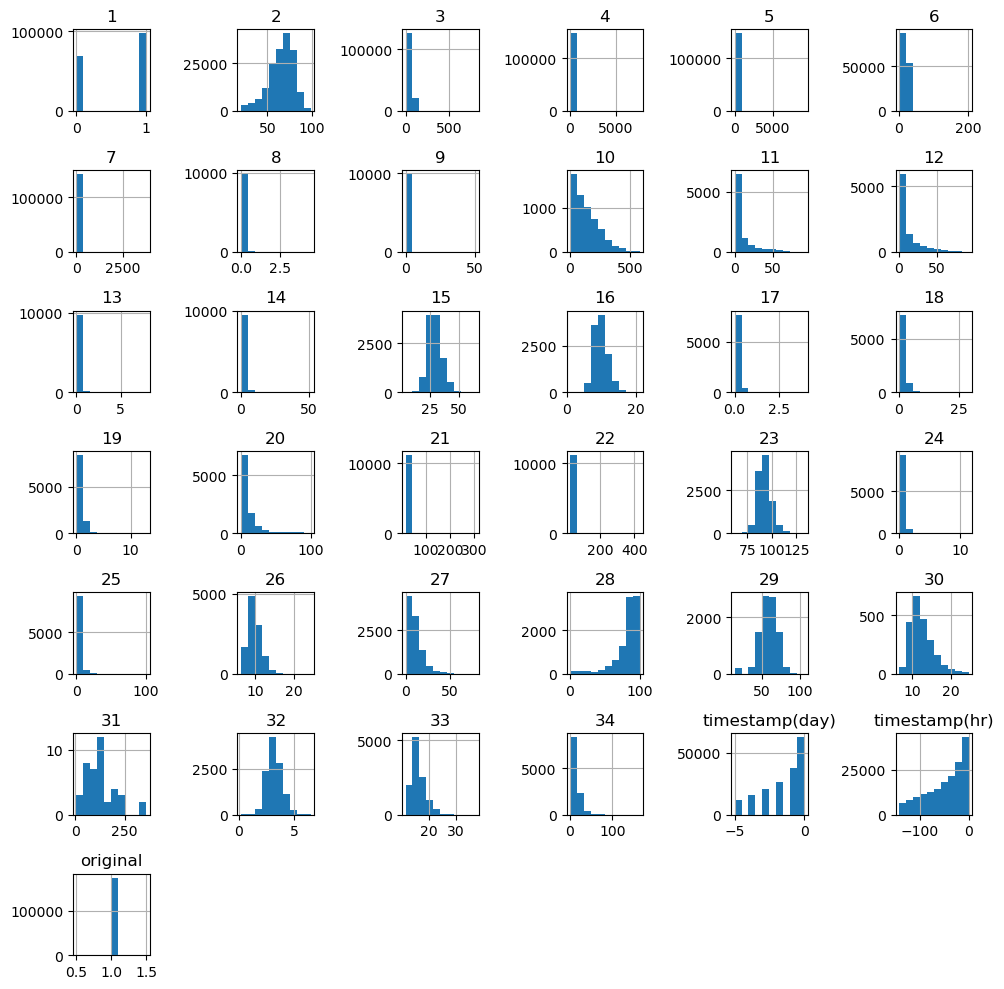

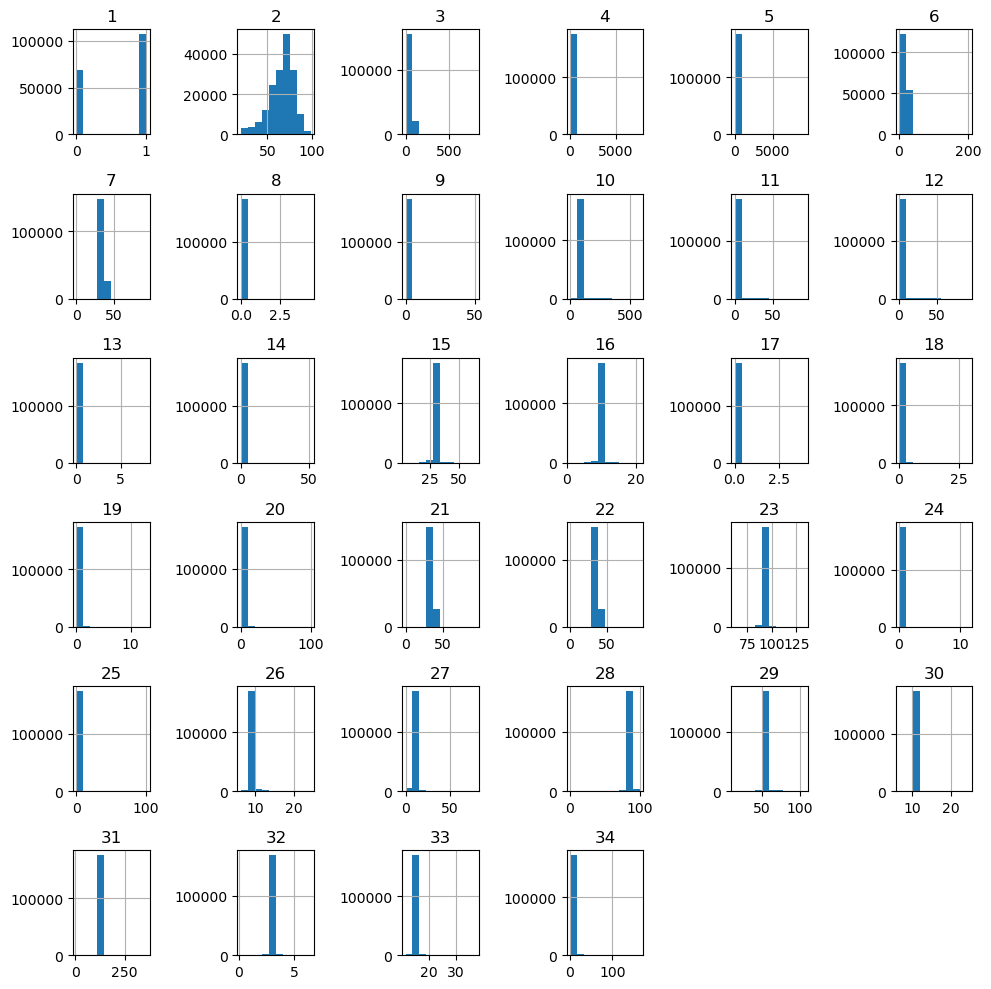

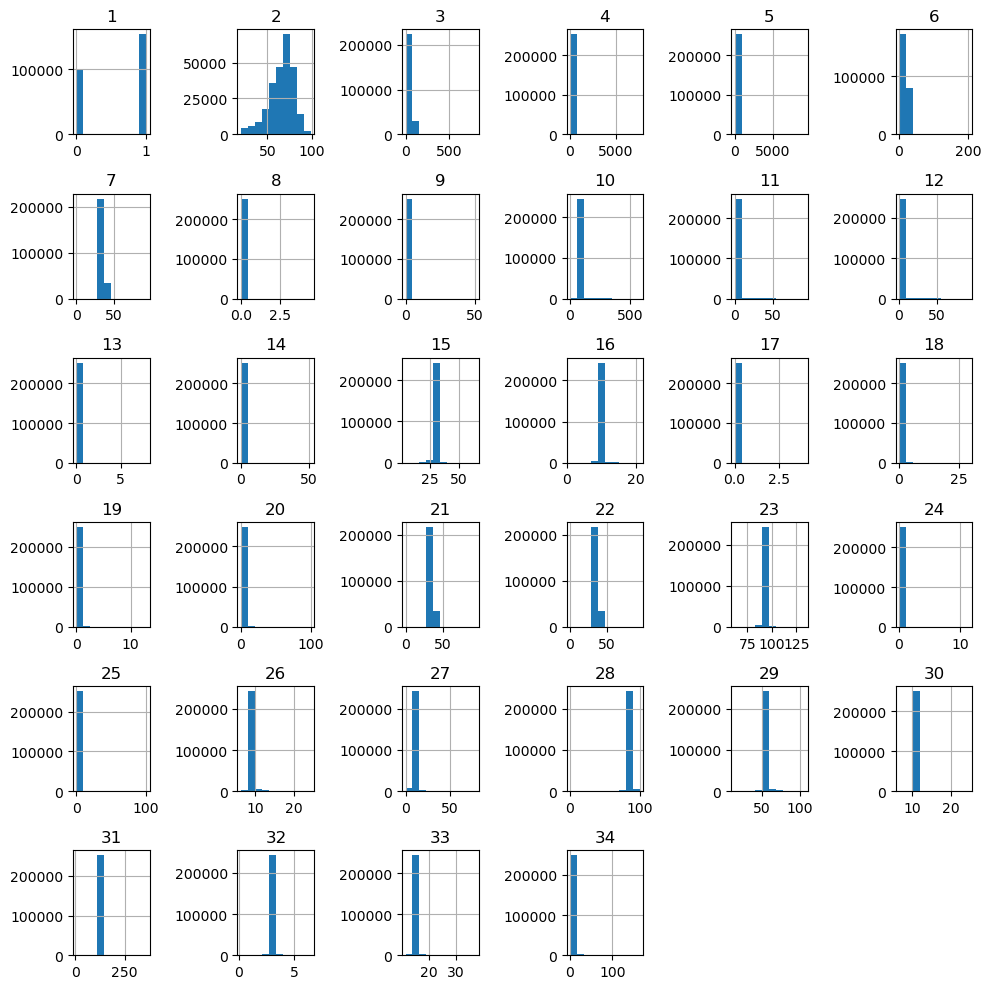

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,0.0,62.0,65.000000,114.000000,96.000000,20.000000,36.900000,0.020000,0.30000,109.6,...,7.400000,10.000000,6.100000,78.600000,60.000000,10.900000,119.0,4.110000,13.600000,7.750000
1,0.0,62.0,63.000000,106.000000,106.000000,19.000000,37.000000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
2,0.0,62.0,94.000000,144.000000,96.000000,20.000000,36.900000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
3,0.0,62.0,88.000000,113.000000,94.000000,15.000000,36.900000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
4,0.0,62.0,83.000000,96.000000,98.000000,20.000000,36.300000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252335,0.0,79.0,60.000000,154.624410,109.126769,20.751179,36.662441,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
252336,1.0,68.0,65.872861,118.000000,103.127139,16.254278,37.809291,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
252337,0.0,72.0,65.000000,114.000000,96.000000,20.000000,37.800000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
252338,0.0,77.0,65.000000,114.000000,96.000000,20.000000,36.900000,0.016061,0.09092,109.6,...,2.751417,10.245518,10.262712,91.927357,63.066512,12.497051,119.0,2.742418,14.287854,8.991296


In [2]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_df = pd.DataFrame(train)
train_df = train_df.loc[np.where(train_df['original']==1)] # remain original is 1

test_df = pd.DataFrame(test)
test_df = test_df.loc[np.where(test_df['original']==1)] # remain original is 1

train_df.hist(figsize=(10, 10))
plt.tight_layout()  # 그래프 간격 조정
plt.show()
# features[0] => gender
# features[1] => age
# timestamp_day
# timestamp_hour
# original => flag of is there any feature[2:-3]

# resolve encoding problem
# 100<= value < 1000 to / 10, 1000< value to / 100
train_df.iloc[:, 6] = train_df.iloc[:, 6].apply(lambda x: x/10 if 100 <= x < 1000 else x/100 if x >= 1000 else x)
train_df.iloc[:, 20] = train_df.iloc[:, 6].apply(lambda x: x/10 if 100 <= x < 1000 else x/100 if x >= 1000 else x)
train_df.iloc[:, 21] = train_df.iloc[:, 6].apply(lambda x: x/10 if 100 <= x < 1000 else x/100 if x >= 1000 else x)

test_df.iloc[:, 6] = test_df.iloc[:, 6].apply(lambda x: x/10 if 100 <= x < 1000 else x/100 if x >= 1000 else x)
test_df.iloc[:, 20] = test_df.iloc[:, 6].apply(lambda x: x/10 if 100 <= x < 1000 else x/100 if x >= 1000 else x)
test_df.iloc[:, 21] = test_df.iloc[:, 6].apply(lambda x: x/10 if 100 <= x < 1000 else x/100 if x >= 1000 else x)

# Non-existent data should be replaced with average values to minimize the impact on the classifier results.
train_df.iloc[:, 0:2] = train_df.iloc[:, 0:2].fillna(round(train_df.iloc[:, 0:2].median()))
train_df.iloc[:, 2:34] = train_df.iloc[:, 2:34].fillna(train_df.iloc[:, 2:34].median())
test_df.iloc[:, 0:2] = test_df.iloc[:, 0:2].fillna(round(train_df.iloc[:, 0:2].median()))
test_df.iloc[:, 2:34] = test_df.iloc[:, 2:34].fillna(train_df.iloc[:, 2:34].median())

# fix the class, to change (-4, -5) to -3

train_df.iloc[:, -3] = train_df.iloc[:, -3].replace([-4, -5], -3)

train_X = train_df.iloc[:, 0:34]
train_y = train_df.iloc[:, -3]
train_y = train_y.astype(int)

test_df.iloc[:, -3] = test_df.iloc[:, -3].replace([-4, -5], -3)

test_X = test_df.iloc[:, 0:34]
test_y = test_df.iloc[:, -3]
test_y = test_y.astype(int)

train_X.hist(figsize=(10, 10))
plt.tight_layout()  # 그래프 간격 조정
plt.show()

# data balancing with SMOTE
sm = SMOTE(sampling_strategy='auto', random_state=10001)
train_X, train_y = sm.fit_resample(train_X, train_y)
train_X.iloc[:, 0:2] = round(train_X.iloc[:, 0:2])

train_y = round(train_y)

train_X.hist(figsize=(10, 10))
plt.tight_layout()  # 그래프 간격 조정
plt.show()
train_X


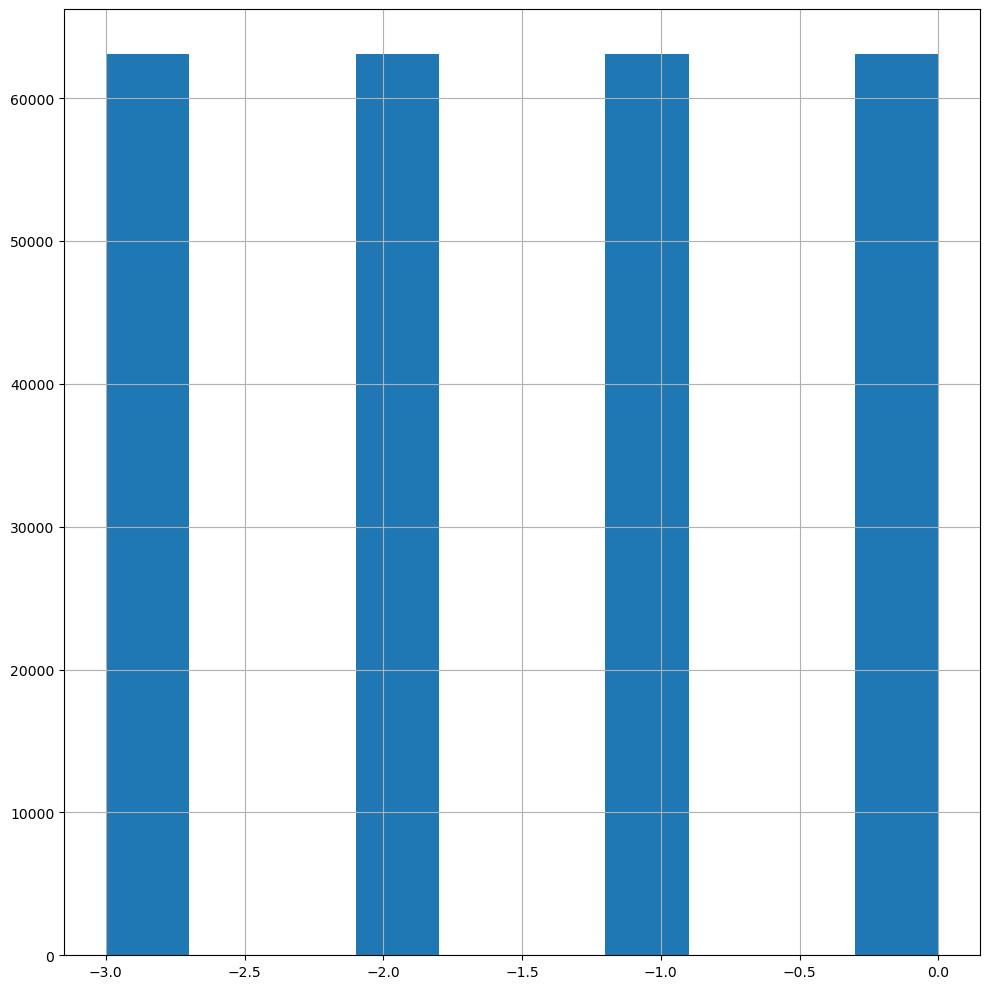

In [3]:
train_y.hist(figsize=(10, 10))
plt.tight_layout()  # 그래프 간격 조정
plt.show()

In [4]:
test_y

0       -3
122      0
123      0
125      0
127      0
        ..
69118    0
69120    0
69122    0
69124    0
69126    0
Name: timestamp(day), Length: 16277, dtype: int32

# EDA


In [5]:
# 1) How many patients are there?
print("Number of patients is {}".format(len(train_X)))
print("Mean of X : \n{}".format(train_X.mean()))
print("Max of X : \n{}".format(train_X.max()))
# 2) What are the mean and median value of the label (day)?
print("Mean of Label(day) : {}".format(train_y.mean()))
print(train_y)
print("Median of Label(day) : {}".format(np.median(train_y)))

print("Mean of each features")
print(np.mean(train_X))

print("Standard deviation of each features")
print(np.std(train_X))
# 3) Perform EDA and calculate the statistics of the dataset: mean, std, correlations among features

Number of patients is 252340
Mean of X : 
1       0.606527
2      65.586411
3      65.244441
4     116.299665
5      97.437763
6      20.598135
7      36.936835
8       0.021139
9       0.210261
10    110.266227
11      4.089835
12      5.993566
13      0.043664
14      0.442837
15     28.835960
16      9.614273
17      0.112013
18      1.121949
19      0.589961
20      6.685342
21     36.936835
22     36.936835
23     92.244214
24      0.385134
25      3.653547
26      9.418836
27      9.013989
28     86.579582
29     59.960223
30     11.806850
31    119.001564
32      3.113967
33     15.630410
34     10.152786
dtype: float64
Max of X : 
1        1.00
2       99.00
3      802.00
4     7652.00
5     9118.00
6      202.00
7       94.00
8        4.48
9       50.00
10     580.80
11      91.70
12      92.00
13       7.89
14      51.50
15      64.20
16      21.20
17       3.96
18      29.20
19      12.84
20     100.00
21      94.00
22      94.00
23     133.10
24      11.43
25     100.00
26 

correlation between features


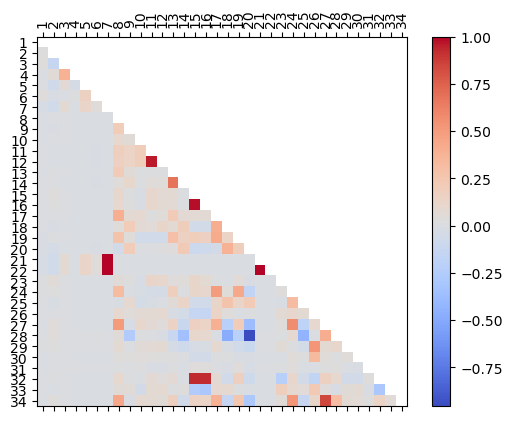

In [6]:
features = train_df.iloc[:, 0:34]

# Calcuate correlation between features
corr_matrix = features.corr()

# mask for show only upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix_masked = corr_matrix.mask(mask)


fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix_masked, cmap='coolwarm')
fig.colorbar(cax)

# Set the labels for the x-axis and y-axis.
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)

# Show the plot.
print("correlation between features")
plt.show()

In [7]:
# positive correlation high : 12/11, 16/15, 21/7, 23/7, 22/21, 32/15, 32/16,
# negative correlation high : 28/20
# we can delete, 15, 16, 11, 20
train_X_feature_reduced = train_X
test_X_feature_reduced = test_X

train_X_feature_reduced = train_X.drop(columns=['1', '2', '21', '22'])
test_X_feature_reduced = test_X.drop(columns=['1', '2', '21', '22'])

print(train_X_feature_reduced)
train_X

                 3           4           5          6          7         8  \
0        65.000000  114.000000   96.000000  20.000000  36.900000  0.020000   
1        63.000000  106.000000  106.000000  19.000000  37.000000  0.020000   
2        94.000000  144.000000   96.000000  20.000000  36.900000  0.020000   
3        88.000000  113.000000   94.000000  15.000000  36.900000  0.020000   
4        83.000000   96.000000   98.000000  20.000000  36.300000  0.020000   
...            ...         ...         ...        ...        ...       ...   
252335   60.000000  154.624410  109.126769  20.751179  36.662441  0.020000   
252336   65.872861  118.000000  103.127139  16.254278  37.809291  0.020000   
252337   65.000000  114.000000   96.000000  20.000000  37.800000  0.020000   
252338   65.000000  114.000000   96.000000  20.000000  36.900000  0.016061   
252339  123.000000  195.210407  101.132358  21.184390  36.860520  0.020000   

              9     10        11        12  ...        25      

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,0.0,62.0,65.000000,114.000000,96.000000,20.000000,36.900000,0.020000,0.30000,109.6,...,7.400000,10.000000,6.100000,78.600000,60.000000,10.900000,119.0,4.110000,13.600000,7.750000
1,0.0,62.0,63.000000,106.000000,106.000000,19.000000,37.000000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
2,0.0,62.0,94.000000,144.000000,96.000000,20.000000,36.900000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
3,0.0,62.0,88.000000,113.000000,94.000000,15.000000,36.900000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
4,0.0,62.0,83.000000,96.000000,98.000000,20.000000,36.300000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252335,0.0,79.0,60.000000,154.624410,109.126769,20.751179,36.662441,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
252336,1.0,68.0,65.872861,118.000000,103.127139,16.254278,37.809291,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
252337,0.0,72.0,65.000000,114.000000,96.000000,20.000000,37.800000,0.020000,0.20000,109.6,...,3.600000,9.400000,8.920000,86.900000,60.000000,11.800000,119.0,3.110000,15.600000,10.030000
252338,0.0,77.0,65.000000,114.000000,96.000000,20.000000,36.900000,0.016061,0.09092,109.6,...,2.751417,10.245518,10.262712,91.927357,63.066512,12.497051,119.0,2.742418,14.287854,8.991296


# Model Selection



In [8]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import roc_curve, auc


In [9]:

X_train = train_X_feature_reduced
y_train = train_y
X_test = test_X_feature_reduced
y_test = test_y

In [10]:
y_train = y_train.replace([-2], 1)
y_train = y_train.replace([-1], 2)
y_train = y_train.replace([0], 3)
y_train = y_train.replace([-3], 0)
y_train = y_train.astype(int)

y_test = y_test.replace([-2], 1)
y_test = y_test.replace([-1], 2)
y_test = y_test.replace([0], 3)
y_test = y_test.replace([-3], 0)
y_test = y_test.astype(int)

# Model Tuning



In [15]:
model = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.4)
model.fit(X_train, y_train)

0:	learn: 1.3778886	total: 97.7ms	remaining: 9.68s
1:	learn: 1.3702735	total: 187ms	remaining: 9.18s
2:	learn: 1.3665623	total: 281ms	remaining: 9.08s
3:	learn: 1.3616372	total: 384ms	remaining: 9.21s
4:	learn: 1.3591734	total: 461ms	remaining: 8.77s
5:	learn: 1.3530590	total: 560ms	remaining: 8.77s
6:	learn: 1.3496737	total: 658ms	remaining: 8.74s
7:	learn: 1.3470686	total: 778ms	remaining: 8.95s
8:	learn: 1.3437665	total: 904ms	remaining: 9.14s
9:	learn: 1.3427286	total: 981ms	remaining: 8.83s
10:	learn: 1.3415425	total: 1.08s	remaining: 8.73s
11:	learn: 1.3365851	total: 1.18s	remaining: 8.68s
12:	learn: 1.3361525	total: 1.26s	remaining: 8.44s
13:	learn: 1.3335413	total: 1.36s	remaining: 8.35s
14:	learn: 1.3329753	total: 1.44s	remaining: 8.16s
15:	learn: 1.3298675	total: 1.55s	remaining: 8.12s
16:	learn: 1.3291128	total: 1.64s	remaining: 8.01s
17:	learn: 1.3266508	total: 1.74s	remaining: 7.91s
18:	learn: 1.3236687	total: 1.82s	remaining: 7.77s
19:	learn: 1.3231927	total: 1.91s	remain

# Model Evaluation / Metrics

In [14]:

y_pred = model.predict(X_test)
# F1 점수 계산
f1 = f1_score(y_test, y_pred, average='weighted')

# 정밀도 계산
precision = precision_score(y_test, y_pred, average='weighted')

# 재현율 계산
recall = recall_score(y_test, y_pred, average='weighted')

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)

# 결과 출력
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

F1 Score: 0.39806171018818826
Precision: 0.38068130334258266
Recall: 0.4469496836026295
Accuracy: 0.4469496836026295


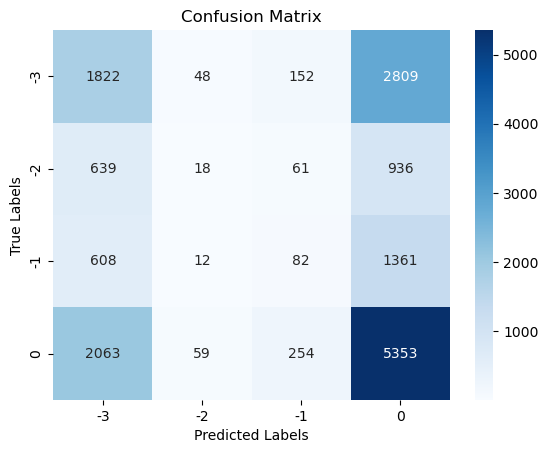

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)
# Heatmap으로 Confusion Matrix 시각화
class_names = ['-3', '-2', '-1', '0']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# 축과 타이틀 설정
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# 그래프 출력
plt.show()

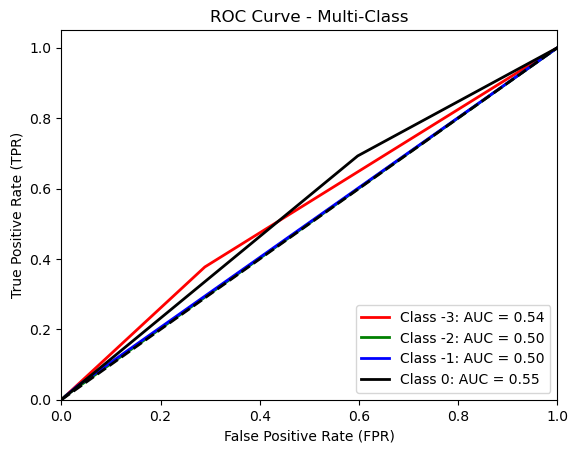

In [17]:
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 각 클래스 별로 ROC 커브 그리기
plt.figure()

colors = ['red', 'green', 'blue', 'black']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {}: AUC = {:.2f}'.format(i-3, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Multi-Class')
plt.legend(loc="lower right")
plt.show()